In [34]:
!git clone https://github.com/francescanaretto/XAI-course_2021

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 2547, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2547 (delta 0), reused 2 (delta 0), pack-reused 2540
Receiving objects: 100% (2547/2547), 698.01 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (283/283), done.
Checking out files: 100% (1945/1945), done.


In [37]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!nvidia-smi

Tue Dec 13 10:41:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    32W /  70W |   1824MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
cd XAI-course_2021/Images/

/content/XAI-course_2021/Images


In [1]:
# black box training
import torch
import numpy as np
from tqdm.notebook import tqdm
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision import transforms, datasets
device = "cuda" if torch.cuda.is_available() else "cpu"

class pl_resnet18(pl.LightningModule):
    def __init__(self):
        super(pl_resnet18,self).__init__()
        self.model = ResNet(layers=[4,4,4,4],block=BasicBlock, num_classes=2)
        self.lr = 1e-3
        self.loss = nn.CrossEntropyLoss()
    def forward(self, x):
        return self.model.forward(x)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        self.log("train_loss", loss, on_epoch=True)
        return loss
    def validation_step(self, valid_batch, batch_idx):
        x, y = valid_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        self.log("val_loss", loss, on_epoch=True)
clf_resnet18 = pl_resnet18()

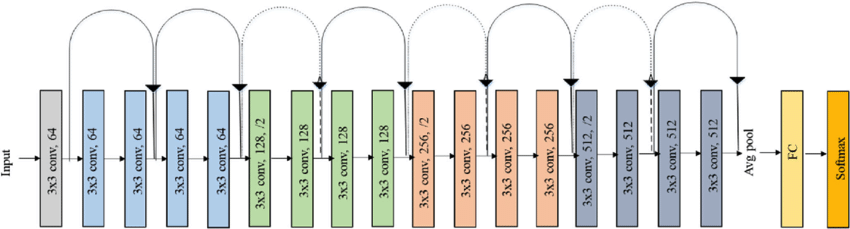

In [3]:
clf_resnet18.load_state_dict(torch.load(f'/content/XAI-course_2021/Images/models/imagenette_resnet18.pt'))
clf_resnet18.to(device)   
clf_resnet18.trainable = False

In [2]:
# -------- training ----------
class Data(pl.LightningDataModule):
    def prepare_data(self):   
        train_data_dir = '/content/XAI-course_2021/Images/datasets/imagenette/train'  
        val_data_dir = '/content/XAI-course_2021/Images/datasets/imagenette/val'  
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(256),
            transforms.CenterCrop(224)])  
        self.train_data = datasets.ImageFolder(train_data_dir, transform=transform)
        self.val_data = datasets.ImageFolder(val_data_dir, transform=transform)
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data,batch_size=64,shuffle=True)
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data,batch_size=64,shuffle=True)
data = Data()
logger = TensorBoardLogger("NN_logs", name=f"resnet18_imagenette", version=0)
es = EarlyStopping(monitor="val_loss", mode="min")
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True)
        return bar
bar = LitProgressBar()
trainer = pl.Trainer(logger=logger, max_epochs=15, callbacks=[es,bar], enable_checkpointing=False, accelerator="gpu")
trainer.fit(clf_resnet18,data)
torch.save(clf_resnet18.state_dict(), f'/content/imagenette_resnet18.pt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 23.7 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
23.7 M    Trainable params
0         Non-trainable params
23.7 M    Total params
94.876    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

In [3]:
import numpy as np

train_data_dir = '/content/XAI-course_2021/Images/datasets/imagenette/train'  
val_data_dir = '/content/XAI-course_2021/Images/datasets/imagenette/val'  
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224)])  
train_data = datasets.ImageFolder(train_data_dir, transform=transform)
val_data = datasets.ImageFolder(val_data_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=32,shuffle=True)

train_preds = []
train_labels = []
val_preds = []
val_labels = []
with torch.no_grad():
    clf_resnet18.eval()
    clf_resnet18.to('cuda')
    for images, labels in train_loader:
        train_preds.append(clf_resnet18.forward(images.to('cuda')).argmax(dim=1).cpu().detach().numpy())
        train_labels.append(labels.data.numpy())
    for images, labels in val_loader:
        val_preds.append(clf_resnet18.forward(images.to('cuda')).argmax(dim=1).cpu().detach().numpy())
        val_labels.append(labels.data.numpy())
train_preds = np.hstack(train_preds)
train_labels = np.hstack(train_labels)
val_preds = np.hstack(val_preds)
val_labels = np.hstack(val_labels)

In [4]:
from sklearn.metrics import classification_report

print(classification_report(train_labels, train_preds, target_names=['golf ball','parachute']))
print(classification_report(val_labels, val_preds, target_names=['golf ball','parachute']))

              precision    recall  f1-score   support

   golf ball       0.99      0.83      0.91       345
   parachute       0.86      0.99      0.92       345

    accuracy                           0.91       690
   macro avg       0.92      0.91      0.91       690
weighted avg       0.92      0.91      0.91       690

              precision    recall  f1-score   support

   golf ball       0.88      0.51      0.64       399
   parachute       0.65      0.93      0.76       390

    accuracy                           0.71       789
   macro avg       0.76      0.72      0.70       789
weighted avg       0.76      0.71      0.70       789



In [8]:
!cp /content/imagenette_resnet_v3.pt /content/drive/MyDrive/

In [6]:
#val/parachute/n03888257_400.JPEG
#val/parachute/ILSVRC2012_val_00038942.JPEG
#train/parachute/ILSVRC2012_val_00010336.JPEG
#train/parachute/ILSVRC2012_val_00022496.JPEG
#train/golf_ball/n03445777_7184.JPEG
#train/golf_ball/n03445777_7794.JPEG
#val/golf_ball/n03445777_551.JPEG
#train/golf_ball/n03445777_759.JPEG

In [122]:
path = './datasets/imagenette/train/golf_ball/n03445777_759.JPEG'

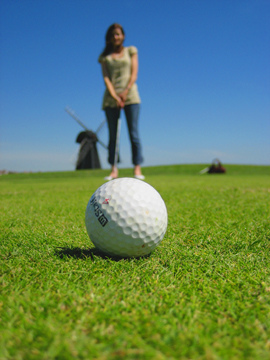

In [123]:
from PIL import Image
image = Image.open(path)
image

prediction:  0


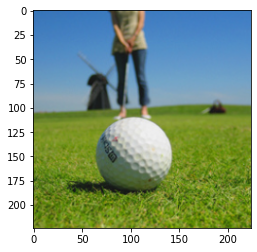

In [124]:
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)])

image = plt.imread(path)
image = transform(torch.tensor(image/255).permute(2,0,1)).float()
plt.imshow(image.permute(1,2,0))
image = image.unsqueeze(0)

with torch.no_grad():
    pred = int(clf_resnet18.forward(image.to('cuda')).cpu().detach().numpy().argmax(axis=1))

print('prediction: ', pred)

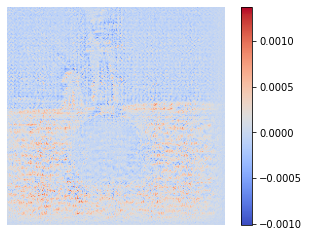

In [127]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(clf_resnet18)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = plt.imread(path)

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    image = transform(torch.tensor(image/255).permute(2,0,1)).float()
    image = image.unsqueeze(0)
    return image

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return clf_resnet18.forward(image.to('cuda'))

# 5) Explain an Instance
intgrad_pt_score = ig.explain(image, pred, 'half', preprocessing, predict, model_type='pytorch',cuda=True)

plt.imshow(np.sum(intgrad_pt_score,axis=-1),cmap='coolwarm')
plt.colorbar()
plt.axis('off');

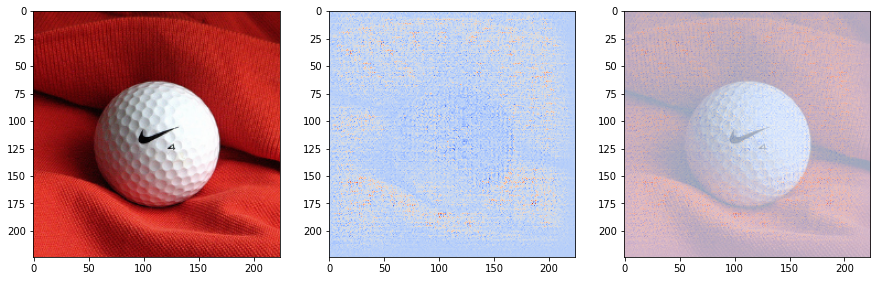

In [114]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).numpy())
ax[1].imshow(np.sum(intgrad_pt_score,axis=-1),cmap='coolwarm')
ax[2].imshow(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).numpy(),alpha=0.5)
ax[2].imshow(np.sum(intgrad_pt_score,axis=-1),cmap='coolwarm',alpha=0.5);

In [115]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/500 [00:00<?, ?it/s]

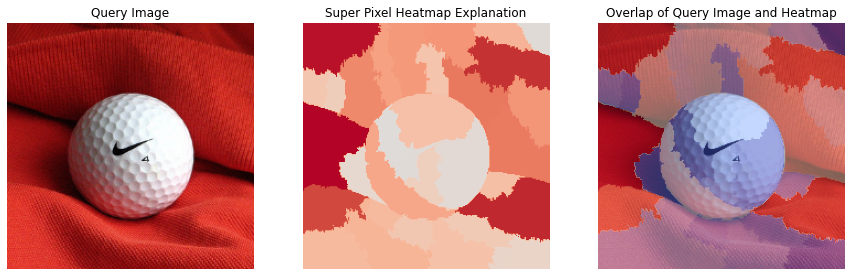

In [116]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# 1) Create the Explainer
lm = LimeXAIImageExplainer(clf_resnet18)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    with torch.no_grad():
        images = torch.tensor(images/255).permute(0,3,1,2).float()
        pred = clf_resnet18(images.to('cuda')).cpu().detach().numpy()
        return pred

# 3) Explain an Instance
explanation = lm.explain(transform(torch.tensor(image).permute(2,0,1)).permute(1,2,0).numpy(), classifier_fn, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(transform(torch.tensor(image).permute(2,0,1)).permute(1,2,0).numpy(), explanation)
lime_score = explanation.heatmap

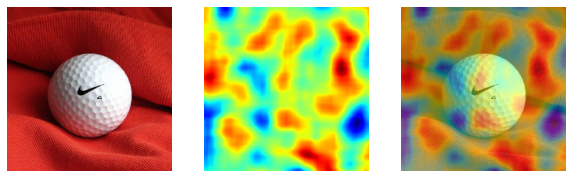

In [117]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size
        
    def predict(self, X):
        with torch.no_grad():
            images = torch.tensor(X).permute(0,3,1,2).float()
            return clf_resnet18(images.to('cuda')).cpu().detach().numpy()
        

model = Rise_model_wrapper(clf_resnet18, (224,224))
rise = RiseXAIImageExplainer(model)
        

N = 500 # number of random masks
s = 10 # cell_size = input_shape / s
p1 = 0.5 # masking probability

rise.fit(N, s, p1)

sal = rise.explain(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).cpu().detach().numpy())
rise_score = sal[pred,:]

fig, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[0].axis('off')

ax[1].imshow(sal[pred,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[2].imshow(sal[pred,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

In [118]:
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


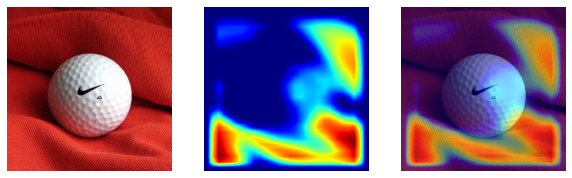

In [119]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

explainer = GradCAMImageExplainer(clf_resnet18)

explainer.fit([list(clf_resnet18.modules())[36]]) #-5,36

attr = explainer.explain(transform(torch.tensor(image).permute(2,0,1)).float().to('cuda').unsqueeze(0), pred, model_type='pytorch')
gradcam_pt_score = attr[0,:]

fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

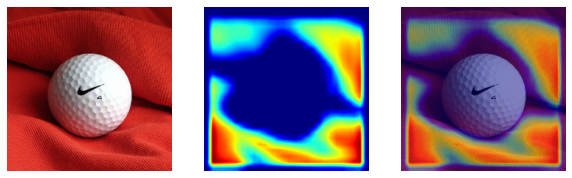

In [120]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

explainer = GradCAMPlusPlusImageExplainer(clf_resnet18)

explainer.fit([list(clf_resnet18.modules())[36]])

attr = explainer.explain(transform(torch.tensor(image).permute(2,0,1)).float().to('cuda').unsqueeze(0), pred, model_type='pytorch')
gradcampp_pt_score = attr[0,:]

fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(transform(torch.tensor(image/255).permute(2,0,1)).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

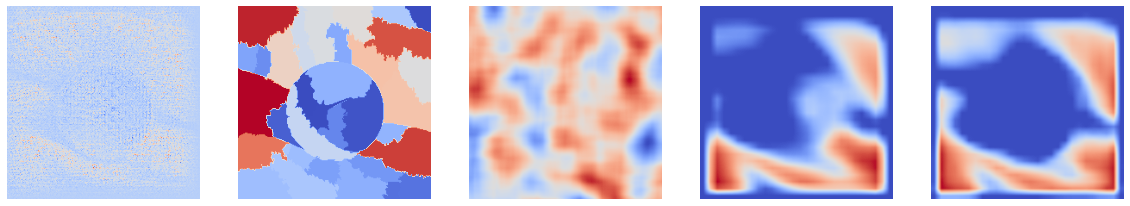

In [121]:
methods = [np.sum(intgrad_pt_score,axis=-1),lime_score,rise_score,gradcam_pt_score,gradcampp_pt_score]
F, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    ax[i].axis(False)
    ax[i].imshow(methods[i],cmap='coolwarm')